# Pynbody halo manipulation

In this notebook, we will demonstrate how we center and rotate a halo along certain vectors. The goal is to manipulate the halo to be in a useful orientation for both visualization and data analysis.

In [1]:
import matplotlib
matplotlib.use("TKAgg")
%matplotlib inline

import pynbody
import numpy as np
import seaborn as sns
from matplotlib import pyplot
from analysis import load_snapshot_and_halos
import analysis.conf as conf

pyplot.rcParams['figure.figsize'] = 8, 6  # that's default image size for this

/Users/kevinyu/Dev/ubiquitous-meow/env/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [2]:
s, h = load_snapshot_and_halos(conf.NOTEBOOK_SAMPLE)

/Users/kevinyu/Dev/ubiquitous-meow/env/lib/python2.7/site-packages/pynbody/simdict.py:92: RuntimeWarning: Assuming default value for property 'omegaM0'=3.09e-01
  name, value), RuntimeWarning)
/Users/kevinyu/Dev/ubiquitous-meow/env/lib/python2.7/site-packages/pynbody/simdict.py:92: RuntimeWarning: Assuming default value for property 'omegaL0'=6.91e-01
  name, value), RuntimeWarning)


## Adjusting halo perspective

We have loaded up a halo catalog from our simulation snapshot. Now, we can visualize it. Lets start by visualizing its the stellar particle density, using `pynbody.plot.image`.

Unfortunately, although the halo we select contains only the particles in the halo itself, its currently centered on the center of the simulation. Odds are, the halo is not centered in this region and thus the density will be very low here, too low to generate an image. If we try to run `pynbody.plot.image(halo.s)`, you will get this error:

```
ValueError: Failed to make a sensible logarithmic image. This probably means there are no particles in the view.
```

So, you will need to first center the image using `pynbody.analysis.halo.center`, and use the keyword arg `mode="pot"` to center the sim to the center of the halo's gravitational potential.

Next, we can rotate the image to be oriented "face-on", along the net angular momentum vector, using `pynbody.analysis.angmom.faceon`. In order to apply the reverse transformations automatically when we are finished, we use python context managers.

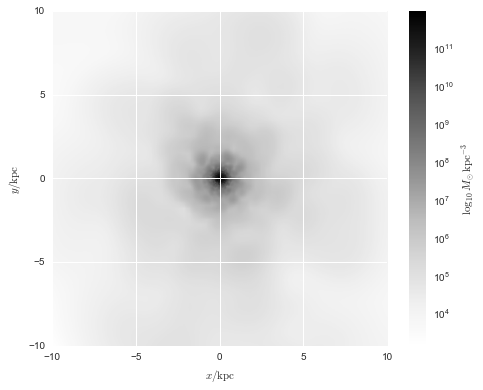

In [3]:
halo = h[2]

# We want to center and rotate our halo
# By using python's context manager, we automatically apply the reverse-transformation afterward
with pynbody.analysis.halo.center(halo, mode="pot"), pynbody.analysis.angmom.faceon(halo):
    pynbody.plot.image(halo.s, width="20 kpc", cmap="Greys")

To better visualize that we are looking face on the halo, we can plot the velocity image using `pynbody.plot.sph.velocity_image`.

Using the `vector_resolution` keyword argument, you can adjust how the density of arrows, or you can use mode="stream" to view the vectors as streams.

The following cell visualizes both faceon and sideon projections of the halo, with different `vector_resolution` arguments for comparison.

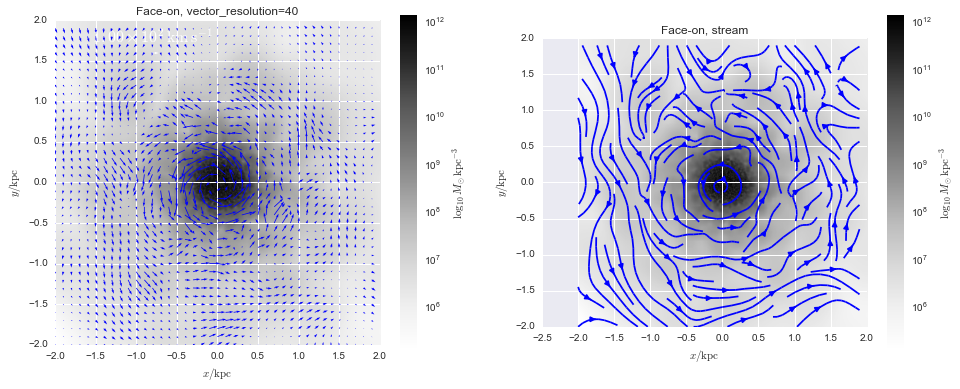

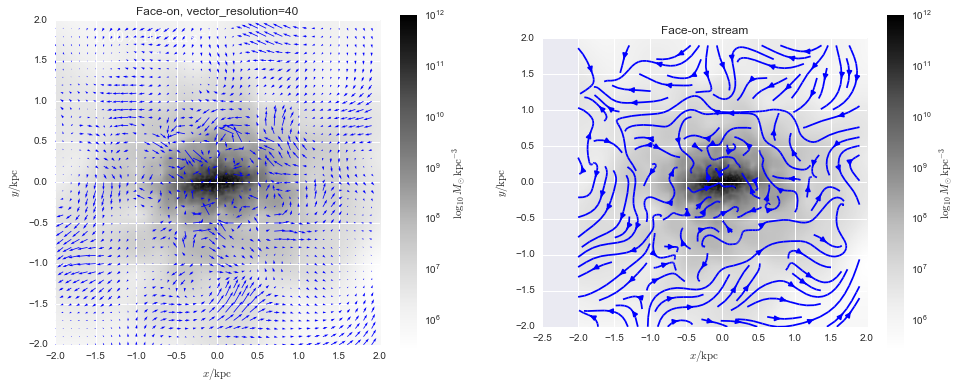

In [4]:
pyplot.rcParams['figure.figsize'] = 16, 6

with pynbody.analysis.halo.center(halo, mode="pot"):
    with pynbody.analysis.angmom.faceon(halo):
        fig = pyplot.figure()

        sub = pyplot.subplot(1, 2, 1)
        pynbody.plot.sph.velocity_image(halo.s, vector_resolution=40, width="4 kpc",
                                        cmap="Greys", vector_color="blue", mode="quiver",
                                        subplot=sub)
        sub.set_title("Face-on, vector_resolution=40")
        
        sub = pyplot.subplot(1, 2, 2)
        pynbody.plot.sph.velocity_image(halo.s, width="4 kpc",
                                        cmap="Greys", vector_color="blue", mode="stream",
                                        subplot=sub)
        sub.set_title("Face-on, stream")

    with pynbody.analysis.angmom.sideon(halo):
        fig = pyplot.figure()

        sub = pyplot.subplot(1, 2, 1)
        pynbody.plot.sph.velocity_image(halo.s, vector_resolution=40, width="4 kpc",
                                        cmap="Greys", vector_color="blue", mode="quiver",
                                        subplot=sub)

        sub.set_title("Face-on, vector_resolution=40")
        
        sub = pyplot.subplot(1, 2, 2)
        pynbody.plot.sph.velocity_image(halo.s, width="4 kpc",
                                        cmap="Greys", vector_color="blue", mode="stream",
                                        subplot=sub)
        sub.set_title("Face-on, stream")

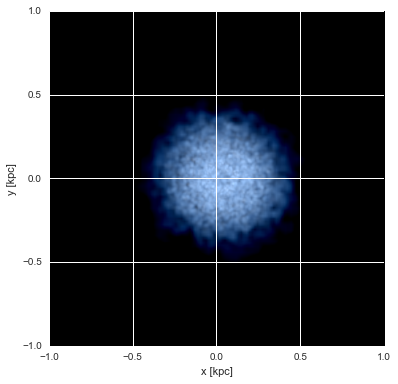

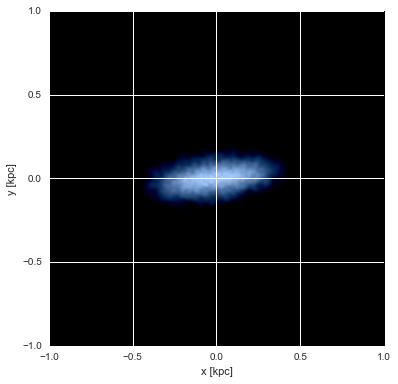

In [5]:
# Render stars through default filter        
with pynbody.analysis.halo.center(halo, mode="pot"):
    with pynbody.analysis.angmom.faceon(halo):
        pyplot.figure()
        pynbody.plot.stars.render(halo.s, width="2 kpc")
    with pynbody.analysis.angmom.sideon(halo):
        pyplot.figure()
        pynbody.plot.stars.render(halo.s, width="2 kpc")

## Generating a profile

Using pynbody, we can also generate profiles using `pynbody.analysis.profile.Profile`. For example, we can generate a rotation curve of orbital velocity vs radial distance, or we can create a mass profile of mass enclosed vs radial distance.

The mass enclosed example will be particularly useful for later on when we want to calculate the half-mass radius of galaxy halos.

In [6]:
halo = h[3]

# Of course, we want to center our halo first.
with pynbody.analysis.halo.center(halo, mode="pot"):
    # create a 2D profile, with 1000 radius bins
    p = pynbody.analysis.profile.Profile(halo.s, nbins=1000, ndim=2)

# print "keys:", p.keys()
# print "derivable keys:", p.derivable_keys()

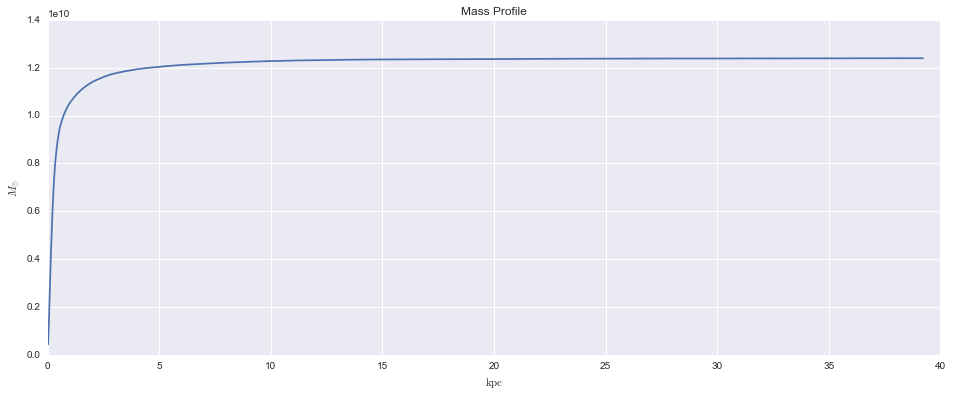

In [7]:
sns.set_style("darkgrid")
latex = "${}$"

# Mass profile
pyplot.figure()
pyplot.title("Mass Profile")
pyplot.plot(p["rbins"], p["mass_enc"])
pyplot.xlabel(latex.format(p["rbins"].units.latex()))
pyplot.ylabel(latex.format(p["mass_enc"].units.latex()))

## Halo slicing

Finally, we will demonstrate slicing a halo. This means, only taking particles within a specified region of the simulation. This can be particularly useful to do analysis only on particles within a certain radius of the halo center, for example.

We can do this using the `pynbody.filt` module. In this example, I will create a slice of particles forming a disc around the center of halo with an arbitrary height. As the radius of my disc, I will use the radius within which half the mass of the halo is contained. To find this half-mass radius, I will use the profiling technique from the previous section.

In [8]:
def get_halfmass_radius(halo):
    """Return radius at which half the stellar mass of the halo is contained"""
    # generate a profile for the halo's stellar particles
    with pynbody.analysis.halo.center(halo, mode="pot"):
        p = pynbody.analysis.profile.Profile(halo.s, nbins=1000, ndim=2)
    
    M_star = sum(halo.s["mass"])
    
    # Find the radius at which half the stellar mass is contained
    # Interpolate between the point before we exceed half the mass and the point after
    for i, mass_enc in enumerate(p["mass_enc"]):
        if mass_enc > 0.5 * M_star:
            return np.mean(p["rbins"][i-1:i+1])

In [9]:
def halfmass_disc_filter(halo, height="50 kpc"):
    """Return a filter that includes a disc of particles along the angular momentum vector"""
    r = get_halfmass_radius(halo)
    with pynbody.analysis.halo.center(halo, mode="pot"), pynbody.analysis.angmom.faceon(halo):
        return pynbody.filt.Disc(r, height)

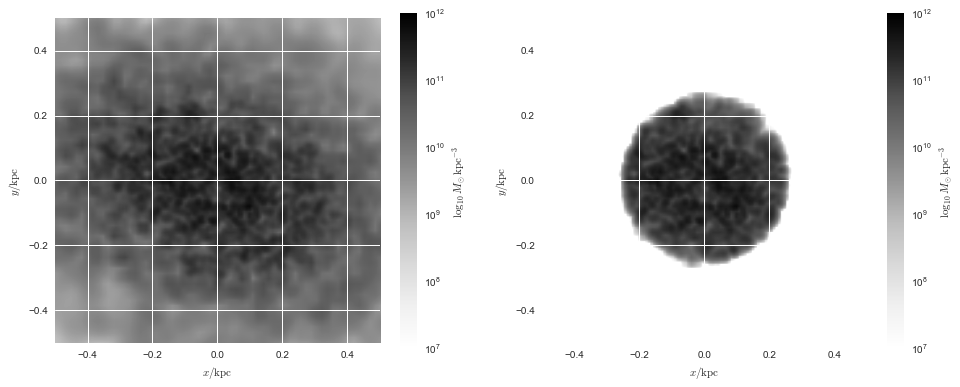

In [10]:
# Generate a plot of the original halo, the sliced disc from a face on perspective
pyplot.rcParams['figure.figsize'] = 16, 6

fig = pyplot.figure()

filt = halfmass_disc_filter(halo)

with pynbody.analysis.halo.center(halo, mode="pot"):
    with pynbody.analysis.angmom.faceon(halo):
        sub = pyplot.subplot(1, 2, 1)
        pynbody.plot.image(halo.s, cmap="Greys", width="1 kpc", subplot=sub)
        pyplot.gca().get_images()[0].set_clim([1e7, 1e12])

        sub = pyplot.subplot(1, 2, 2)
        pynbody.plot.image(halo[filt].s, cmap="Greys", width="1 kpc", subplot=sub)
        pyplot.gca().get_images()[0].set_clim([1e7, 1e12])